**This notebook is an exercise in the [Intro to Deep Learning](https://www.kaggle.com/learn/intro-to-deep-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/overfitting-and-underfitting).**

---


# Introduction #

In this exercise, you’ll learn how to improve training outcomes by including an early stopping callback to prevent overfitting.

When you're ready, run this next cell to set everything up!

In [1]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.deep_learning_intro.ex4 import *

First load the *Spotify* dataset. Your task will be to predict the popularity of a song based on various audio features, like `'tempo'`, `'danceability'`, and `'mode'`.

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('../input/dl-course-data/spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


In [3]:
spotify.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [4]:
# Select cateogorical columns

for i in spotify.columns:
    if spotify[i].dtype =='object':
        print(i)

track_id
track_name
track_artist
track_album_id
track_album_name
track_album_release_date
playlist_name
playlist_id
playlist_genre
playlist_subgenre


In [5]:
# Select cateogorical columns
numeric_cols = [cname for cname in spotify.columns if spotify[cname].dtype in ['int64', 'float64']]

print(numeric_cols)

['track_popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']


Let's start with the simplest network, a linear model. This model has low capacity.

Run this next cell without any changes to train a linear model on the *Spotify* dataset.

2022-12-07 19:45:34.903207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 19:45:34.994776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 19:45:34.995571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 19:45:34.997473: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Minimum Validation Loss: 0.1980


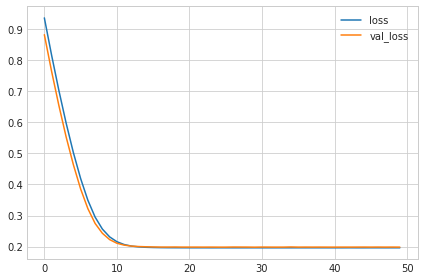

In [6]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history) ## this will make numpy array to a data frame
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [7]:
history_df.columns

Index(['loss', 'val_loss'], dtype='object')

In [8]:
history_df

,loss,val_loss
0,0.936407,0.882327
1,0.816237,0.764220
2,0.702937,0.654529
3,0.597923,0.553394
4,0.502646,0.463702
5,0.419108,0.385575
6,0.349073,0.322080
7,0.294739,0.274350
8,0.256270,0.242741
9,0.231146,0.222407


It's not uncommon for the curves to follow a "hockey stick" pattern like you see here. This makes the final part of training hard to see, so let's start at epoch 10 instead:

Minimum Validation Loss: 0.1980


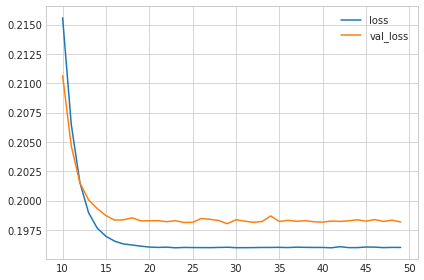

In [9]:
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 1) Evaluate Baseline

What do you think? Would you say this model is underfitting, overfitting, just right?

In [10]:
# View the solution (Run this cell to receive credit!)
q_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

The gap between these curves is quite small and the validation loss never increases, so it's more likely that the network is underfitting than overfitting. It would be worth experimenting with more capacity to see if that's the case.

Now let's add some capacity to our network. We'll add three hidden layers with 128 units each. Run the next cell to train the network and see the learning curves.

Epoch 1/50
49/49 [==============================] - 1s 5ms/step - loss: 0.2312 - val_loss: 0.2070
Epoch 2/50
49/49 [==============================] - 0s 3ms/step - loss: 0.2003 - val_loss: 0.2012
Epoch 3/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1949 - val_loss: 0.1989
Epoch 4/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1918 - val_loss: 0.1981
Epoch 5/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1901 - val_loss: 0.1966
Epoch 6/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1880 - val_loss: 0.1977
Epoch 7/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1875 - val_loss: 0.1976
Epoch 8/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1855 - val_loss: 0.1978
Epoch 9/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1849 - val_loss: 0.1976
Epoch 10/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1842 - val_loss: 0.1976
Epoch 11/50
49/49 [

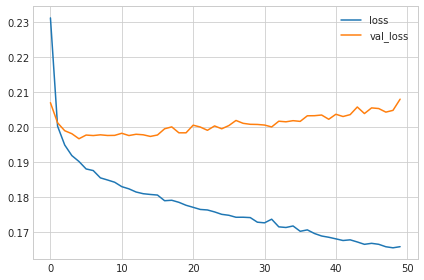

In [11]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 2) Add Capacity

What is your evaluation of these curves? Underfitting, overfitting, just right?

In [12]:
# View the solution (Run this cell to receive credit!)
q_2.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

Now the validation loss begins to rise very early, while the training loss continues to decrease. This indicates that the network has begun to overfit. At this point, we would need to try something to prevent it, either by reducing the number of units or through a method like early stopping. (We'll see another in the next lesson!)

# 3) Define Early Stopping Callback

Now define an early stopping callback that waits 5 epochs (`patience'`) for a change in validation loss of at least `0.001` (`min_delta`) and keeps the weights with the best loss (`restore_best_weights`).

In [13]:
from tensorflow.keras import callbacks

# YOUR CODE HERE: define an early stopping callback
early_stopping = callbacks.EarlyStopping(
                    min_delta=0.001,# minimium amount of change to count as an improvement
                    patience=5,# how many epochs to wait before stopping
                    restore_best_weights=True)

# Check your answer
q_3.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [14]:
# Lines below will give you a hint or solution code
#q_3.hint()
#q_3.solution()

Now run this cell to train the model and get the learning curves. Notice the `callbacks` argument in `model.fit`.

Epoch 1/50
49/49 [==============================] - 0s 4ms/step - loss: 0.2748 - val_loss: 0.2109
Epoch 2/50
49/49 [==============================] - 0s 3ms/step - loss: 0.2034 - val_loss: 0.2039
Epoch 3/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1976 - val_loss: 0.2031
Epoch 4/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1945 - val_loss: 0.2008
Epoch 5/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1925 - val_loss: 0.1993
Epoch 6/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1908 - val_loss: 0.1996
Epoch 7/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1889 - val_loss: 0.1992
Epoch 8/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1878 - val_loss: 0.1989
Epoch 9/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1870 - val_loss: 0.1985
Epoch 10/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1860 - val_loss: 0.1979
Epoch 11/50
49/49 [

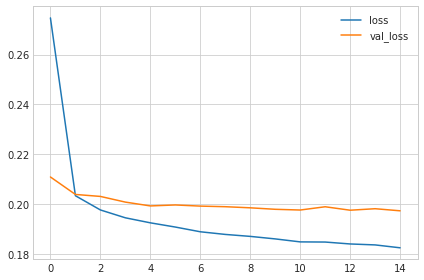

In [15]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

Epoch 1/50
49/49 [==============================] - 1s 4ms/step - loss: 0.2274 - val_loss: 0.2067
Epoch 2/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1996 - val_loss: 0.2013
Epoch 3/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1946 - val_loss: 0.2000
Epoch 4/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1924 - val_loss: 0.1990
Epoch 5/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1902 - val_loss: 0.1989
Epoch 6/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1885 - val_loss: 0.1994
Epoch 7/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1872 - val_loss: 0.1975
Epoch 8/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1859 - val_loss: 0.1980
Epoch 9/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1855 - val_loss: 0.1990
Epoch 10/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1854 - val_loss: 0.1983
Epoch 11/50
49/49 [

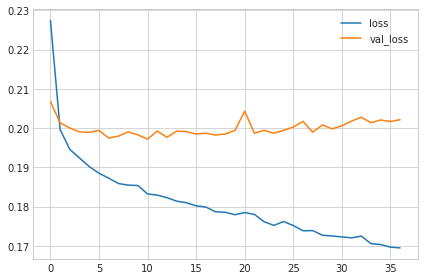

In [16]:
early_stopping2 = callbacks.EarlyStopping(
                    min_delta=0.001,# minimium amount of change to count as an improvement
                    patience=30,# how many epochs to wait before stopping
                    restore_best_weights=True)

# Check your answer
q_3.check()

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping2]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 4) Train and Interpret

Was this an improvement compared to training without early stopping?

In [17]:
# View the solution (Run this cell to receive credit!)
q_4.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

The early stopping callback did stop the training once the network began overfitting. Moreover, by including `restore_best_weights` we still get to keep the model where validation loss was lowest.

If you like, try experimenting with `patience` and `min_delta` to see what difference it might make.

# Keep Going #

Move on to [**learn about a couple of special layers**](https://www.kaggle.com/ryanholbrook/dropout-and-batch-normalization): batch normalization and dropout.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/intro-to-deep-learning/discussion) to chat with other learners.*